In [1]:
# Import all libraries
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = 'drive/MyDrive/Bangkit 2022/Capstone Project/Fixed_Dataset.csv'

In [20]:
# Load dataset
#data = pd.read_csv('/content/UpdatedResumeDataSet.csv', engine='python')
data = pd.read_csv(dataset) # Comment this line and uncomment the above line if this does not work for you
#data.head()

**DROP LABELS WHICH HAVING FEW SAMPLES (OPTIONAL)**

In [5]:
# Print unique categories of resumes
kategori = dict(data['title'].value_counts())
print(kategori)
print(len(kategori))

{'CUSTOMER SERVICE REPRESENTATIVE': 205, 'SALES FLOOR ASSOCIATE': 200, 'Flatbed Truck Driving Job - Rider Policy Available': 115, 'Sales Representative': 84, 'KFC Team Member': 79, 'Retail Counter Sales': 75, 'ONLINE MEDICAL BILLING & CODING TRAINING - LEARN FROM HOME': 68, 'Parts Delivery': 56, 'Merchandise Associate': 54, 'Customer Service Representative': 49, 'Hiring Van & Company Drivers - Earn Up To $70k': 43, 'Local CDL A Truck Driver': 42, 'CDL A Delivery Truck Driver - Home Daily!': 41, 'Staff Accountant': 39, 'MEDICAL BILLING & CODING CAREER TRAINING - LOCAL TRAINING AVAILABLE': 39, 'CDL A Truck Driver - Home Daily!': 35, 'ONLINE MEDICAL ASSISTANT CAREER TRAINING - LEARN FROM HOME': 34, 'Sales Executive - B2B - In Person or Remote': 33, 'Administrative Assistant': 33, 'Warehouse Associate': 33, 'CDL A Local Delivery Truck Driver - Home Daily!': 31, 'Retail Merchandiser': 29, 'CDL A Delivery Truck Driver in West Texas': 26, 'Machine Operator': 26, 'MEDICAL ASSISTANT CAREER TRAI

In [6]:
buang = []

for x in kategori:
  if kategori[x] < 10:
    buang.append(x)

print(buang)
print(len(buang))

['Licensed Real Estate Professional', '13J Fire Control Specialist', 'Dentist - DDS / DMD', 'Maintenance Mechanic', 'Pharmacy Technician', 'Real Estate Agent -- Quick Interview Process', 'Retail Sales Associate', 'Company Driver Job', 'Production Associate', 'Independent Sales Representative - Part-Time/Flex Schedule', 'Data Analyst', 'Restaurant Team Member', 'Dedicated Route Driving Job', 'Manufacturing Associate', 'Transportation Security Officer (TSO)', 'Physical Therapist - Travel Contract', 'Maintenance Supervisor', 'Project Coordinator', 'Account Executive', 'Medical Assistant', 'Payroll Administrator', 'Paralegal', 'Restaurant General Manager', 'Warehouse', 'Accounting Manager', '88M Truck Driver', '42A Human Resources Specialist', 'Insurance Agent', 'Class A CDL - Over-the-Road (OTR) Truck Driver', 'Accounts Receivable Clerk', 'Paramedic OR Nurse - LPN, LVN or RN', 'Mac Tools Route Sales / Outside Sales Distributor - Full Training', "Real Estate Buyer's Agent", 'Real Estate Ag

In [7]:
for x in buang:
  kategori.pop(x)

In [8]:
print(kategori)
print(len(kategori))

{'CUSTOMER SERVICE REPRESENTATIVE': 205, 'SALES FLOOR ASSOCIATE': 200, 'Flatbed Truck Driving Job - Rider Policy Available': 115, 'Sales Representative': 84, 'KFC Team Member': 79, 'Retail Counter Sales': 75, 'ONLINE MEDICAL BILLING & CODING TRAINING - LEARN FROM HOME': 68, 'Parts Delivery': 56, 'Merchandise Associate': 54, 'Customer Service Representative': 49, 'Hiring Van & Company Drivers - Earn Up To $70k': 43, 'Local CDL A Truck Driver': 42, 'CDL A Delivery Truck Driver - Home Daily!': 41, 'Staff Accountant': 39, 'MEDICAL BILLING & CODING CAREER TRAINING - LOCAL TRAINING AVAILABLE': 39, 'CDL A Truck Driver - Home Daily!': 35, 'ONLINE MEDICAL ASSISTANT CAREER TRAINING - LEARN FROM HOME': 34, 'Sales Executive - B2B - In Person or Remote': 33, 'Administrative Assistant': 33, 'Warehouse Associate': 33, 'CDL A Local Delivery Truck Driver - Home Daily!': 31, 'Retail Merchandiser': 29, 'CDL A Delivery Truck Driver in West Texas': 26, 'Machine Operator': 26, 'MEDICAL ASSISTANT CAREER TRAI

In [21]:
#print(kategori.keys())
for x in buang:
  data = data[data.title != x]

In [22]:
data = data.reset_index()

In [23]:
#data.head()

**BACK INTO THE MAIN**

In [24]:
data_size = len(data)
print(data_size)

2525


In [ ]:
#data.head()

In [25]:
# Get set of stopwords
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english')+['``',"''"])

In [33]:
# Function to clean resume text
def clean_text(resume_text):
    resume_text = re.sub('http\S+\s*', ' ', resume_text)  # remove URLs
    resume_text = re.sub('RT|cc', ' ', resume_text)  # remove RT and cc
    resume_text = re.sub('#\S+', '', resume_text)  # remove hashtags
    resume_text = re.sub('@\S+', '  ', resume_text)  # remove mentions
    resume_text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@
    [\]^_`{|}~"""), ' ', resume_text)  # remove punctuations
    resume_text = re.sub(r'[^\x00-\x7f]',r' ', resume_text) 
    resume_text = re.sub('\s+', ' ', resume_text)  # remove extra whitespace
    resume_text = resume_text.lower()  # convert to lowercase
    resume_text = re.sub('job', '', resume_text)
    resume_text = re.sub('work', '', resume_text)
    resume_text = re.sub('experience', '', resume_text)
    resume_text = re.sub('skills', '', resume_text)
    resume_text = re.sub('description', '', resume_text)
    resume_text = re.sub('requirements', '', resume_text)
    resume_text = re.sub('ability', '', resume_text)
    resume_text_tokens = word_tokenize(resume_text)  # tokenize
    filtered_text = [w for w in resume_text_tokens if not w in stopwords_set]
    # remove stopwords
    return ' '.join(filtered_text)

In [31]:
# Print a sample original feature and label
print(data['description'][0])
print(data['title'][0])

Job Description


Job Requirements
Qualified candidates will have at least 1-2 years specialty store experience and a strong visual merchandising background.
Sales Associate


In [34]:
# Clean the description
data['cleaned_description'] = data.description.apply(lambda x: clean_text(x))
print(data['cleaned_description'][0])

data['cleaned_title'] = data.title.apply(lambda x: clean_text(x))
print(data['cleaned_title'][0])

come us spencer spirit halloween ing best brightest colleagues help us deliver fun product possible guests fast paced take seriously always good laugh end day walk stores halls corporate office see firsthand laidback irreverent firm believers true tattoos piercings common water cooler convos whether critiquing new exclusive costumes quality testing newly implemented software technology teams understand importance ing collaboratively challenge status quo achieve goals keep pushing go beyond looking top talent become part team check benefits competitive salary incentive opportunity career advancement 30 discount merchandise responsibilities responsible selling store merchandise guests maintaining company standard customer service demonstrates merchandise ording company guidelines product knowledge operates store pos ring sales assists merchandising stocking general upkeep store education required looking creative high energy fun people great customer service qualified candidates least 1 

In [35]:
# Get features and labels from data and shuffle
features = data['cleaned_description'].values
#print(features)
original_labels = data['cleaned_title'].values
#print(original_labels)
labels = original_labels[:]
#print(labels)

for i in range(data_size):
  labels[i] = str(labels[i].lower())  # convert to lowercase
  labels[i] = labels[i].replace(" ", "")  # use hyphens to convert multi-token labels into single tokens
#print(labels)

import random
random.seed(20)
features, labels = shuffle(features, labels, random_state=20)

# Print example feature and label
print(features[0])
print(labels[0])

interested online medical assisting training medical career help rapid online medical assistant training nbsp national reditation count nbsp financial aid assistance nbsp nbsp career placement services medical assisting career high reward high demand medical assisting passionate rewarding career alongside physicians variety medical settings learn varying medical assistants cross trained perform administrative clinical areas responsibilities vary per healthcare facility depending upon size location practice health care expands growing population physicians hire assistants perform routine administrative clinical duties allowing physicians see patients ording u department labor employment medical assistants projected grow 23 percent 2018 2028 4x faster average upations bls gov nbsp benefits online trainingzero transportation coststraining scheduleno class timesindividual pacingchoose medical careermy medical career portal individuals seeking career medical assistant field aligned numerous

In [36]:
# Split for train and test
train_split = 0.8
train_size = int(train_split * data_size)

train_features = features[:train_size]
train_labels = labels[:train_size]

test_features = features[train_size:]
test_labels = labels[train_size:]

# Print size of each split
print(len(train_labels))
print(len(test_labels))

2020
505


In [37]:
# Tokenize feature data and print word dictionary
vocab_size = 10000
oov_tok = '<OOV>'

feature_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
feature_tokenizer.fit_on_texts(train_features)

feature_index = feature_tokenizer.word_index
print(dict(list(feature_index.items())))

# Print example sequences from train and test datasets
train_feature_sequences = feature_tokenizer.texts_to_sequences(train_features)
print(train_feature_sequences[0])

test_feature_sequences = feature_tokenizer.texts_to_sequences(test_features)
print(test_feature_sequences[0])

{'<OOV>': 1, 'customer': 2, 'store': 3, 'medical': 4, 'time': 5, 'training': 6, 'career': 7, 'nbsp': 8, 'customers': 9, 'team': 10, 'service': 11, 'company': 12, 'sales': 13, 'home': 14, 'provide': 15, 'get': 16, 'drivers': 17, 'duties': 18, 'environment': 19, 'must': 20, 'cash': 21, 'ing': 22, 'merchandise': 23, 'health': 24, 'position': 25, 'day': 26, 'years': 27, 'pay': 28, 'benefits': 29, 'new': 30, 'high': 31, 'industry': 32, '000': 33, 'safety': 34, 'opportunity': 35, 'paid': 36, 'support': 37, 'safe': 38, 'us': 39, 'assigned': 40, 'required': 41, 'learn': 42, 'associates': 43, 'services': 44, 'business': 45, 'one': 46, 'clean': 47, 'employment': 48, 'great': 49, 'include': 50, 'retail': 51, 'chalk': 52, 'family': 53, 'earn': 54, 'ounting': 55, 'including': 56, 'responsible': 57, 'management': 58, '1': 59, 'may': 60, 'shift': 61, 'today': 62, 'make': 63, 'products': 64, 'year': 65, 'quality': 66, 'based': 67, 'members': 68, 'link': 69, 'equipment': 70, 'program': 71, 'available':

In [38]:
# Tokenize label data and print label dictionary
label_tokenizer = Tokenizer(lower=True)
label_tokenizer.fit_on_texts(labels)

label_index = label_tokenizer.word_index
print(dict(list(label_index.items())))

# Print example label encodings from train and test datasets
train_label_sequences = label_tokenizer.texts_to_sequences(train_labels)
print(train_label_sequences[0])

test_label_sequences = label_tokenizer.texts_to_sequences(test_labels)
print(test_label_sequences[0])

{'customerservicerepresentative': 1, 'salesfloorassociate': 2, 'flatbedtruckdrivingriderpolicyavailable': 3, 'salesrepresentative': 4, 'kfcteammember': 5, 'retailcountersales': 6, 'onlinemedicalbillingcodingtraininglearnhome': 7, 'partsdelivery': 8, 'merchandiseassociate': 9, 'hiringvancompanydriversearn70k': 10, 'localcdltruckdriver': 11, 'cdldeliverytruckdriverhomedaily': 12, 'medicalbillingcodingcareertraininglocaltrainingavailable': 13, 'staffountant': 14, 'cdltruckdriverhomedaily': 15, 'onlinemedicalassistantcareertraininglearnhome': 16, 'administrativeassistant': 17, 'warehouseassociate': 18, 'salesexecutiveb2bpersonremote': 19, 'cdllocaldeliverytruckdriverhomedaily': 20, 'retailmerchandiser': 21, 'medicalassistantcareertraininglocalmedicaltrainingavailable': 22, 'onlinecriminaljusticecareertraininglearnhome': 23, 'srountant': 24, 'machineoperator': 25, 'cdldeliverytruckdriverwesttexas': 26, 'dentalassistantgeneraldentistrypractice': 27, 'securityofficer': 28, 'outsidesalesrepres

In [39]:
# Pad sequences for feature data
max_length = 200
trunc_type = 'post'
pad_type = 'post'

train_feature_padded = pad_sequences(train_feature_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)
test_feature_padded = pad_sequences(test_feature_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

# Print example padded sequences from train and test datasets
#print(train_feature_padded[0])
#print(test_feature_padded[0])

In [40]:
# Model
embedding_dim = 32
num_categories = len(label_index) + 1

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
  #tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(embedding_dim/2))),
  # use ReLU in place of tanh function since they are very good alternatives of each other.
  tf.keras.layers.Dense(128, activation='relu'),
  # Add a Dense layer with 25 units and softmax activation for probability distribution
  tf.keras.layers.Dense(num_categories, activation='softmax'),])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 64)          16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 96)                12384     
                                                                 
Total params: 363,616
Trainable params: 363,616
Non-trai

In [41]:
# Compile the model and convert train/test data into NumPy arrays
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Features
train_feature_padded = np.array(train_feature_padded)
test_feature_padded = np.array(test_feature_padded)

# Labels
train_label_sequences = np.array(train_label_sequences)
test_label_sequences = np.array(test_label_sequences)

# Print example values
#print(train_feature_padded[0])
#print(train_label_sequences[0])
#print(test_feature_padded[0])
#print(test_label_sequences[0])

In [42]:
# Train the neural network
num_epochs = 100

history = model.fit(train_feature_padded, train_label_sequences, epochs=num_epochs, shuffle = True, validation_data=(test_feature_padded, test_label_sequences), verbose=2)

Epoch 1/100
64/64 - 13s - loss: 4.1202 - accuracy: 0.1069 - val_loss: 3.3280 - val_accuracy: 0.1644 - 13s/epoch - 208ms/step
Epoch 2/100
64/64 - 2s - loss: 2.9281 - accuracy: 0.2718 - val_loss: 2.4288 - val_accuracy: 0.3485 - 2s/epoch - 27ms/step
Epoch 3/100
64/64 - 2s - loss: 2.1571 - accuracy: 0.4510 - val_loss: 1.9150 - val_accuracy: 0.5149 - 2s/epoch - 27ms/step
Epoch 4/100
64/64 - 2s - loss: 1.6681 - accuracy: 0.5470 - val_loss: 1.5506 - val_accuracy: 0.5723 - 2s/epoch - 27ms/step
Epoch 5/100
64/64 - 2s - loss: 1.3234 - accuracy: 0.6480 - val_loss: 1.3010 - val_accuracy: 0.6653 - 2s/epoch - 37ms/step
Epoch 6/100
64/64 - 2s - loss: 1.0477 - accuracy: 0.7203 - val_loss: 1.1238 - val_accuracy: 0.7069 - 2s/epoch - 32ms/step
Epoch 7/100
64/64 - 2s - loss: 0.8580 - accuracy: 0.7728 - val_loss: 1.0231 - val_accuracy: 0.7525 - 2s/epoch - 27ms/step
Epoch 8/100
64/64 - 2s - loss: 0.7323 - accuracy: 0.7960 - val_loss: 0.9608 - val_accuracy: 0.7545 - 2s/epoch - 27ms/step
Epoch 9/100
64/64 - 2

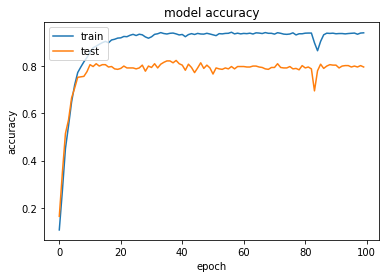

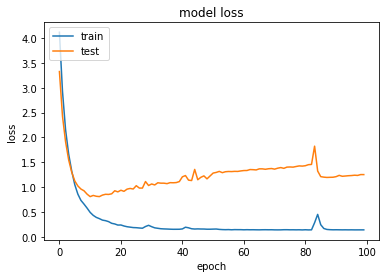

In [43]:
# Plot the training and validation loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**PREDICTION**

In [44]:
# Save reverse dictionary of labels to encodings
label_to_encoding = dict(list(label_index.items()))
print(label_to_encoding)

encoding_to_label = {}
for k, v in label_to_encoding.items():
  encoding_to_label[v] = k
print(encoding_to_label)

{'customerservicerepresentative': 1, 'salesfloorassociate': 2, 'flatbedtruckdrivingriderpolicyavailable': 3, 'salesrepresentative': 4, 'kfcteammember': 5, 'retailcountersales': 6, 'onlinemedicalbillingcodingtraininglearnhome': 7, 'partsdelivery': 8, 'merchandiseassociate': 9, 'hiringvancompanydriversearn70k': 10, 'localcdltruckdriver': 11, 'cdldeliverytruckdriverhomedaily': 12, 'medicalbillingcodingcareertraininglocaltrainingavailable': 13, 'staffountant': 14, 'cdltruckdriverhomedaily': 15, 'onlinemedicalassistantcareertraininglearnhome': 16, 'administrativeassistant': 17, 'warehouseassociate': 18, 'salesexecutiveb2bpersonremote': 19, 'cdllocaldeliverytruckdriverhomedaily': 20, 'retailmerchandiser': 21, 'medicalassistantcareertraininglocalmedicaltrainingavailable': 22, 'onlinecriminaljusticecareertraininglearnhome': 23, 'srountant': 24, 'machineoperator': 25, 'cdldeliverytruckdriverwesttexas': 26, 'dentalassistantgeneraldentistrypractice': 27, 'securityofficer': 28, 'outsidesalesrepres

In [54]:
# Create padded sequence for example
skills = 'communicate'
example_sequence = feature_tokenizer.texts_to_sequences([skills])
example_padded = pad_sequences(example_sequence, maxlen=max_length, padding=pad_type, truncating=trunc_type)
example_padded = np.array(example_padded)
print(example_padded)

[[795   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]


In [55]:
# Make a prediction
prediction = model.predict(example_padded)

In [56]:
# Verify that prediction has correct format
print(prediction[0])
print(len(prediction[0]))  
print(np.sum(prediction[0]))  # should be 1

[4.7856e-10 2.4126e-04 1.2575e-11 2.2590e-16 1.2568e-04 4.8365e-12
 2.2928e-05 1.7227e-09 6.9734e-04 4.7580e-12 4.7582e-09 6.5706e-20
 4.1479e-18 2.4604e-14 6.1282e-11 2.8438e-19 6.4383e-10 1.6453e-06
 4.8236e-08 2.6063e-14 1.2167e-19 2.2011e-12 4.5515e-15 7.5527e-01
 1.4986e-12 3.9069e-08 2.1366e-19 3.9445e-12 2.0537e-12 3.6933e-05
 2.6491e-06 9.6839e-08 3.2684e-19 5.6101e-11 6.6439e-11 2.8575e-12
 7.0238e-05 3.3568e-15 1.3595e-18 1.1034e-01 2.5311e-08 1.1494e-11
 3.7035e-18 6.1757e-07 3.6643e-08 3.9880e-05 7.2166e-03 7.1072e-09
 7.0346e-11 2.0776e-17 1.4505e-03 4.6920e-08 3.2139e-08 8.3632e-12
 2.7527e-06 7.1767e-21 3.4761e-21 8.1881e-02 4.9544e-13 2.0355e-10
 2.6987e-11 6.6435e-03 1.9390e-19 1.9815e-08 1.6529e-17 8.0872e-14
 3.6778e-14 5.8971e-18 3.0828e-09 1.5718e-06 4.5385e-07 1.1877e-14
 2.5444e-20 5.2198e-09 8.0301e-11 2.0528e-22 2.0088e-03 1.2021e-12
 1.4843e-17 1.3294e-20 2.4307e-16 1.0028e-17 5.5141e-18 9.5102e-07
 7.3349e-08 1.3430e-20 1.2258e-04 1.8341e-08 2.7681e-17 3.4459

In [57]:
# Find maximum value in prediction and its index
print(max(prediction[0]))  # confidence in prediction (as a fraction of 1)
print(np.argmax(prediction[0])) 

0.7552653
23


In [58]:
# Indices of top 5 most probable solutions
indices = np.argpartition(prediction[0], -5)[-5:]
indices = indices[np.argsort(prediction[0][indices])]
indices = list(reversed(indices))
print(indices)

[23, 39, 57, 94, 46]


In [59]:
for x in indices:
  print(encoding_to_label[x])

onlinecriminaljusticecareertraininglearnhome
regionaltruckdriving
projectmanager
productioner
assistantstoremanager


In [60]:
# Save model
model.save('model.h5')

**LOAD THE MODEL**

In [ ]:
load_model = tf.keras.models.load_model('drive/MyDrive/Bangkit 2022/Capstone Project/Final Method/model_ver1.h5')

**EXTRAS**

In [ ]:
# Define the neural network
number_of_labels = len(label_index)
embedding_dim = 64

model = tf.keras.Sequential([
  # Add an Embedding layer expecting input vocab of size 6000, and output embedding dimension of size 64 we set at the top
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=300),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  #tf.keras.layers.Dense(embedding_dim, activation='relu'),

  # use ReLU in place of tanh function since they are very good alternatives of each other.
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(embedding_dim, activation='relu'),

  # Add a Dense layer with 25 units and softmax activation for probability distribution
  tf.keras.layers.Dense(number_of_labels, activation='softmax')
])

model.summary()